## LDA Modeling, No-Gram

In [1]:
#set up sys
import os, sys
sys.path.append('../PMC_func')


#python basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from collections import Counter

#spacy stuff
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP
import en_core_web_sm

#gensim stuff
from gensim.models import CoherenceModel, LdaMulticore,LdaModel
from gensim.models.callbacks import ConvergenceMetric
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this

#custom dependencies
import PMC_module

#other
import pickle
import warnings
warnings.filterwarnings('ignore')

### Import Data
- Pickled Gensim Objects
- Composite Data Frame

In [2]:
nogram_filename = "../pickled_data/nogram_corpus.pkl"
bigram_filename = "../pickled_data/bigram_corpus.pkl"
trigram_filename = "../pickled_data/trigram_corpus.pkl"
df_lemmatized_texts = "../pickled_data/df_lemmatized_texts.pkl"

with open(nogram_filename, "rb") as f:
    nogram_list_lemmatized_texts, nogram_corpus, nogram_id2word = pickle.load(f)

with open(bigram_filename, "rb") as g:
    bigram_list_lemmatized_texts, bi_corpus, bi_id2word = pickle.load(g)
    
with open(trigram_filename, "rb") as h:
    trigram_list_lemmatized_texts, tri_corpus, tri_id2word = pickle.load(h)
    
with open(df_lemmatized_texts, "rb") as m:
    df_lemmatized_texts = pickle.load(m)

In [3]:
# store raw texts as a list for later
df_list = df_lemmatized_texts.text.tolist()

### Gensim LDA modeling - Hyper Parameter Tunning

#### Coherence Score

In [4]:
logging.basicConfig(filename='model_callbacks.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

convergence_logger = ConvergenceMetric(logger='shell')

In [5]:
num_topics_list = list(range(5,20,5))
model_lists = []
coherence_list = []

chunksize = 1000
passes = 4
iterations = 200
eval_every = 1
callbacks = [convergence_logger]

for num_topics in num_topics_list:
    lda_model = LdaModel(id2word=nogram_id2word, 
                         num_topics=num_topics,
                         corpus=nogram_corpus,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         callbacks= callbacks)
                             
    coherence_model_lda = CoherenceModel(model=lda_model, texts=nogram_list_lemmatized_texts, dictionary=nogram_id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    model_lists.append(lda_model)
    coherence_list.append(coherence_score)
    print("LDA model/coherence complete for num_topics = ",num_topics, "; score = ", coherence_score)

LDA model/coherence complete for num_topics =  5 ; score =  0.5196303169244544
LDA model/coherence complete for num_topics =  10 ; score =  0.5265127206832199
LDA model/coherence complete for num_topics =  15 ; score =  0.5013044420655975


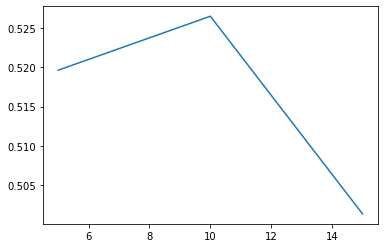

In [6]:
plt.plot(num_topics_list,coherence_list)

#### Topic Component Distribution - 5 topics

In [7]:
opt_topic_index = 0
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

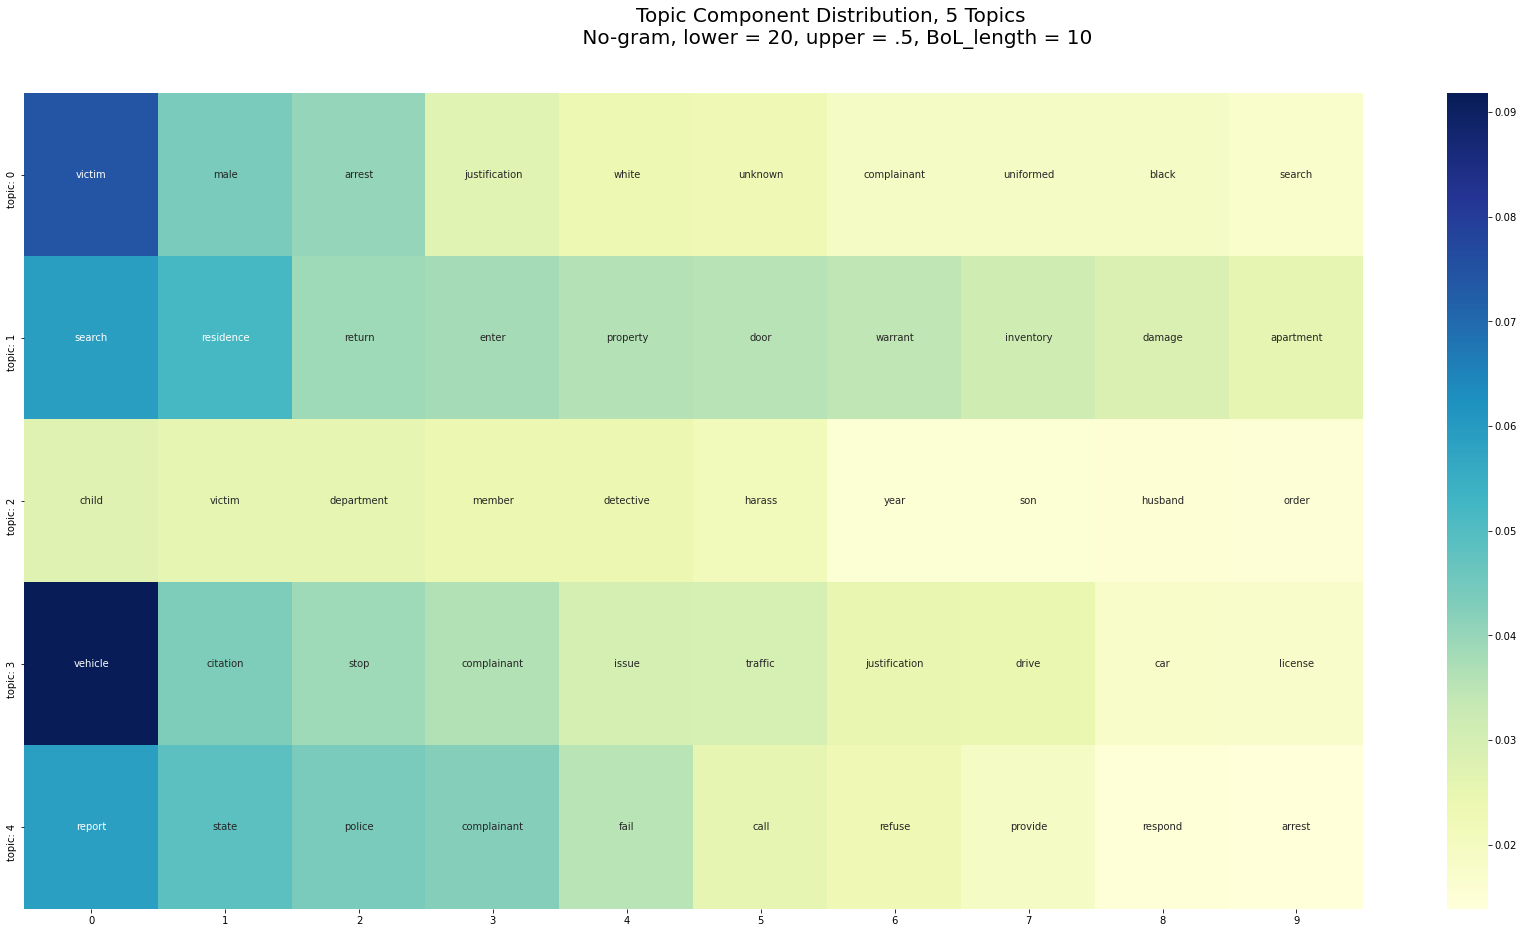

In [8]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n No-gram, lower = 20, upper = .5, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_nogram_5topics1.png')

#### pyLDAvis Principal Component Visualization

In [9]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_nogram_5topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], nogram_corpus, nogram_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

#### Most Represetative Documents


In [10]:
dom_topic_df_5 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],nogram_corpus, nogram_list_lemmatized_texts,df_list)
top_representatives_5 = PMC_module.return_top_representatives(dom_topic_df_5, num_reps = 10)

In [11]:
top_representatives_5[top_representatives_5['Dominant_Topic'] == 3].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
30,29355,3.0,0.8692,"[vehicle, citation, stop, complainant, issue, ...","[complainant, allege, accuse, officer, issue, ...",The complainant alleged that the accused\noffi...
31,10898,3.0,0.8661,"[vehicle, citation, stop, complainant, issue, ...","[reporting, party, allege, accuse, officer, is...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
32,33338,3.0,0.8555,"[vehicle, citation, stop, complainant, issue, ...","[complainant, allege, accuse, officer, justifi...",The complainant alleged that the accused\noffi...
33,11152,3.0,0.8548,"[vehicle, citation, stop, complainant, issue, ...","[reporting, party, allege, accuse, officer, ha...",The reporting party alleged that the accused\n...
34,12567,3.0,0.8536,"[vehicle, citation, stop, complainant, issue, ...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
35,29354,3.0,0.8504,"[vehicle, citation, stop, complainant, issue, ...","[complainant, allege, accuse, officer, issue, ...",The complainant alleged that the accused\noffi...
36,12566,3.0,0.8493,"[vehicle, citation, stop, complainant, issue, ...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
37,22798,3.0,0.8475,"[vehicle, citation, stop, complainant, issue, ...","[reporting, party, allege, accuse, officer, is...",The reporting party alleged that the accused\n...
38,5767,3.0,0.8445,"[vehicle, citation, stop, complainant, issue, ...","[reporting, party, allege, justification, accu...","The reporting party alleges that, without\njus..."
39,4926,3.0,0.8327,"[vehicle, citation, stop, complainant, issue, ...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...


In [12]:
topic_of_interest = 3
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_5[top_representatives_5['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 3
---------
The complainant alleged that the accused
officer issued her three false citations for
not having a city sticker properly displayed
on her vehicle. Tickets #
The complainant alleged that the accused
officer issued her three false citations for
not having a city sticker nroperlv displayed
on her vehicle. Ticket
------
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER ISSUED HIM A
CITATION WITHOUT JUSTIFICATION.
EXPIRED PLATES/TEMPORARY
REGISTRATION:
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER ISSUED HIM A
CITATION WITHOUT JUSTIFICATION.
EXPIRED PLATES/TEMPORARY
REGISTRATION:
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER ISSUED HIM A
CITATION WITHOUT JUSTIFICATION.
REAR OR FRONT PLATE:
------
The complainant alleged that the accused
officer, without justification, issued hima
citation as he parked his vehicle.
The complainant alleged that the accused
officer, without justification, issued him a
citation as he parked his vehicle.
The complainant allege

#### Topic Component Distribution - 10 topics

In [28]:
opt_topic_index = 1
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

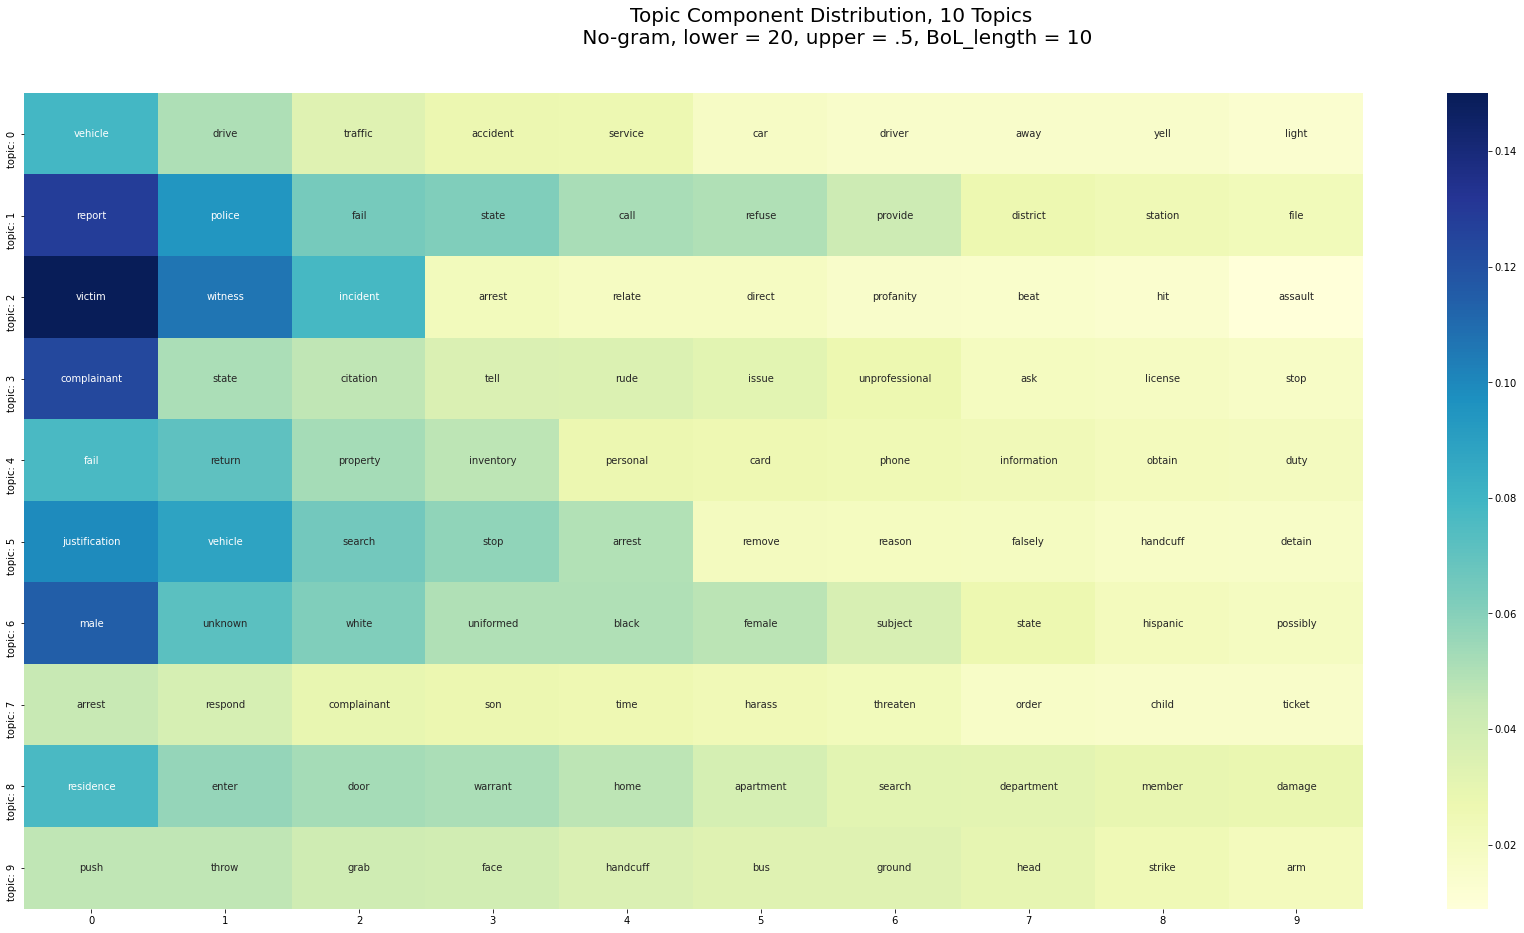

In [33]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu", vmax=.15)
plt.suptitle("Topic Component Distribution, 10 Topics \n No-gram, lower = 20, upper = .5, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_nogram_10topics1.png')

#### pyLDAvis Principal Component Visualization

In [15]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_nogram_10topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], nogram_corpus, nogram_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

#### Most Represetative Documents


In [16]:
dom_topic_df_10 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],nogram_corpus, nogram_list_lemmatized_texts,df_list)
top_representatives_10 = PMC_module.return_top_representatives(dom_topic_df_10, num_reps = 10)

In [34]:
top_representatives_10[top_representatives_10['Dominant_Topic'] == 8].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
80,2988,8.0,0.7539,"[residence, enter, door, warrant, home, apartm...","[victim, allege, accuse, officer, probable, ca...",The victim alleges that the accused officers\n...
81,2987,8.0,0.7539,"[residence, enter, door, warrant, home, apartm...","[victim, allege, accuse, officer, probable, ca...",The victim alleges that the accused officers\n...
82,2519,8.0,0.6032,"[residence, enter, door, warrant, home, apartm...","[enter, residence, permission, search, residen...",ENTERED RESIDENCE WITHOUT\nPERMISSION AND SEAR...
83,4552,8.0,0.5825,"[residence, enter, door, warrant, home, apartm...","[reporting, party, allege, accuse, officer, en...",The Reporting Party alleged the accused\noffic...
84,33258,8.0,0.5817,"[residence, enter, door, warrant, home, apartm...","[accuse, fail, indebtedness, city, accuse, fai...",that the accused failed to\nindebtedness to th...
85,4300,8.0,0.5787,"[residence, enter, door, warrant, home, apartm...","[report, accuse, compliance, indebtedness, cit...",It is reported that the accused was not in\nco...
86,15542,8.0,0.5787,"[residence, enter, door, warrant, home, apartm...","[report, accuse, compliance, indebtedness, cit...",It is reported that the accused was not in\nco...
87,15527,8.0,0.5787,"[residence, enter, door, warrant, home, apartm...","[report, accuse, compliance, indebtedness, cit...",It is reported that the accused was not in\nco...
88,15530,8.0,0.5787,"[residence, enter, door, warrant, home, apartm...","[report, accuse, compliance, indebtedness, cit...",It is reported that the accused was not in\nco...
89,15590,8.0,0.5787,"[residence, enter, door, warrant, home, apartm...","[report, accuse, compliance, indebtedness, cit...",It is reported that the accused was not in\nco...


In [35]:
topic_of_interest = 8
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_10[top_representatives_10['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 8
---------
The victim alleges that the accused officers
had no probable cause, arest warrant, or
search warrant to enter their residence
The victim alleges that the accused officers
had no probable cause, arest warrant, or
search warrant to enter their residence.
The victim alleges that the accused officers
had no probable cause, arest warrant, or
search warrant to enter their residence.
The victim alleges that the accused officers
had no probable cause, arest warrant, or
search warrant to enter their residence.
The victim alleges that the accused officers
had no probable cause, arest warrant, or
search warrant to enter their residence
------
The victim alleges that the accused officers
had no probable cause, arest warrant, or
search warrant to enter their residence
The victim alleges that the accused officers
had no probable cause, arest warrant, or
search warrant to enter their residence.
The victim alleges that the accused officers
had no probable cause, arest warrant, or
se

#### Topic Component Distribution - 15 topics

In [19]:
opt_topic_index = 2
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

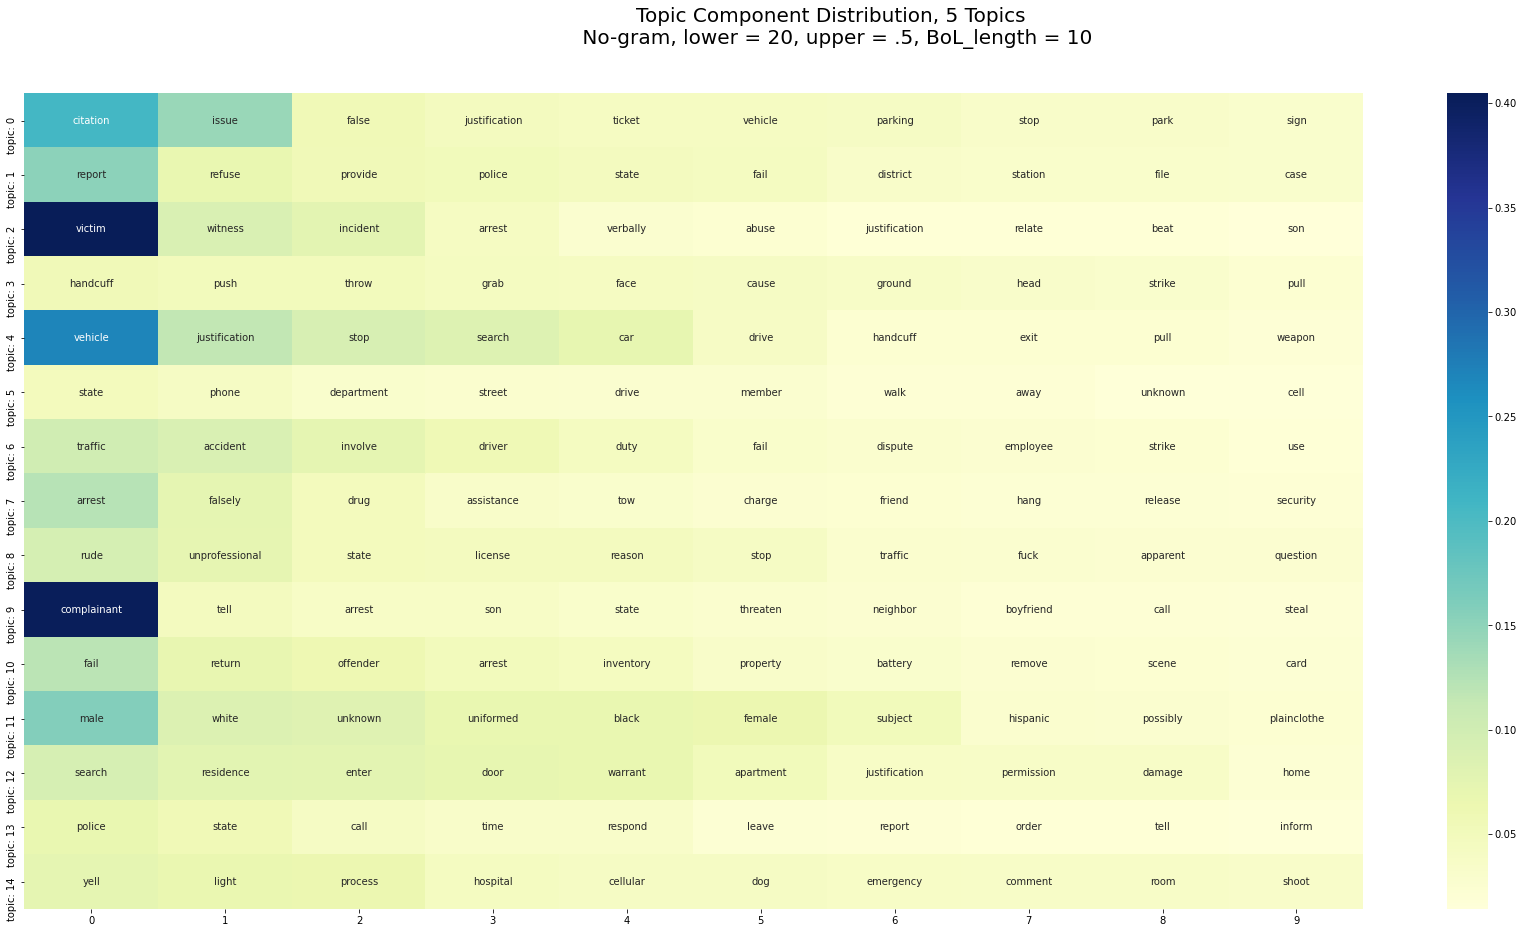

In [20]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n No-gram, lower = 20, upper = .5, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_nogram_15topics1.png')

#### pyLDAvis Principal Component Visualization

In [21]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_nogram_15topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], nogram_corpus, nogram_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


#### Most Represetative Documents


In [22]:
dom_topic_df_15 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],nogram_corpus, nogram_list_lemmatized_texts,df_list)
top_representatives_15 = PMC_module.return_top_representatives(dom_topic_df_15, num_reps = 10)

In [23]:
top_representatives_15[top_representatives_15['Dominant_Topic'] == 4].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
40,10304,4.0,0.7626,"[vehicle, justification, stop, search, car, dr...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
41,5764,4.0,0.7072,"[vehicle, justification, stop, search, car, dr...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
42,21997,4.0,0.6813,"[vehicle, justification, stop, search, car, dr...","[reporting, party, allege, accuse, stop, appro...",The reporting party alleged that the accused\n...
43,10264,4.0,0.6627,"[vehicle, justification, stop, search, car, dr...","[reporting, party, allege, accuse, lieutenant,...",The reporting party alleged that the accused\n...
44,10265,4.0,0.6627,"[vehicle, justification, stop, search, car, dr...","[reporting, party, allege, accuse, lieutenant,...",The reporting party alleged that the accused\n...
45,21007,4.0,0.6605,"[vehicle, justification, stop, search, car, dr...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
46,7054,4.0,0.6142,"[vehicle, justification, stop, search, car, dr...","[object, vehicle, state, object, strike, rear,...",OBJECT AT HIS VEHICLE. HE STATES\nTHAT ALTHOUG...
47,19361,4.0,0.6119,"[vehicle, justification, stop, search, car, dr...","[reporting, party, allege, accuse, stop, order...",The reporting party alleged that the accused\n...
48,24210,4.0,0.5979,"[vehicle, justification, stop, search, car, dr...","[reporting, party, allege, accuse, approach, v...",The reporting party alleged that the accused\n...
49,10307,4.0,0.5963,"[vehicle, justification, stop, search, car, dr...","[reporting, party, allege, accuse, officer, se...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...


In [24]:
topic_of_interest = 4
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_15[top_representatives_15['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 4
---------
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS.
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED THE
VICTIM, PULLED HIM FROM HIS
VEHICLE AND SEARCHED HIS VEHICLE
WITHOUT JUSTIFICATION.
------
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED HIM
WITHOUT JUSTIFICATION. HE ALSO
ALLEGES THAT THE ACCUSED OFFICER
HANDCUFFED HIM AND SEARCHED HIM
AND HIS VEHICLE.
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFIC